In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch.nn as nn
import torch

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

from config import Settings, get_config, get_default_config
from models.gcn_model import *

from data.data_generator import tsp_instance_reader

from utils.tsplib import read_tsplib_coor, read_tsplib_opt, write_tsplib_prob
from utils.tsplib2 import ReaderTSP, PlotterTSP

from utils.tsplib2_graph import GraphBuilder

In [2]:
#path_tsplib = r'../../ML-Constructive/version1/data/test/TSPLIB/'
path_tsplib = r'./data/TSPLib/instances'
path_tsplib_opt = r'./data/TSPLib/optimal'
files = [f for f in os.listdir(path=path_tsplib) if f.endswith('.tsp')]

problem_set = []
for item in files:
    problem = {'name': item, 'size': int(re.findall('[0-9]+', item)[0])}
    problem_set.append(problem)

#order problem set by size, ranging from 100 to 1748
problem_set.sort(key=lambda x: x['size'], reverse=False)

df_ps = pd.DataFrame.from_dict(problem_set)

### 1. Read a TSP instance

In [41]:
tsp_inst_name = 'rd100.tsp'
full_tsp_inst = os.path.join(path_tsplib, tsp_inst_name)

tspReader = ReaderTSP()
n_points, coord_buff, distance_matrix, inst_name, optimal_tour = tspReader.read_instance(full_tsp_inst)


#### 1.1 Rescale instance

In [27]:
x_y_min = np.min(coord_buff, axis=0)
scale = 1.0 / np.max(np.max(coord_buff, axis=0)-x_y_min)
node_coord = coord_buff - x_y_min
node_coord *= scale
distance_matrix *= scale

In [28]:

plotter = PlotterTSP(None)
G = GraphBuilder(pos=coord_buff, dist_matrix=distance_matrix)

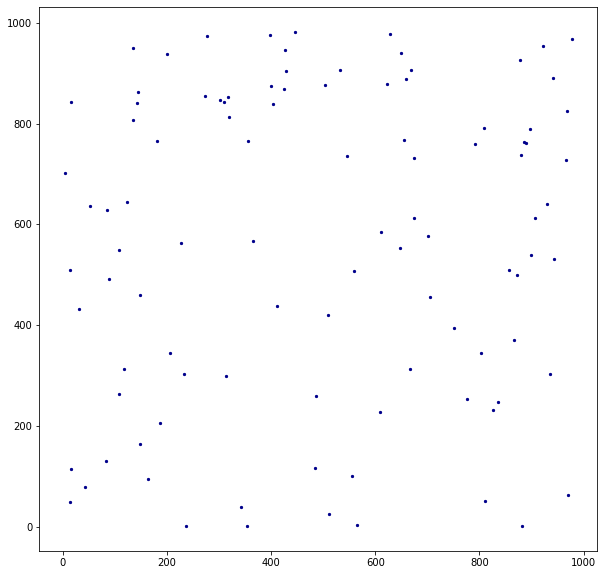

In [29]:
plt.figure(figsize=(10,10))
plotter.plot_points(coord_buff)
plt.show()

### 2. Graph Sampling

In [81]:
def convertmesh_to_listOfTuples(mesh:list):
    flat_list = []
    listOfTuples = []
    for l in mesh:    
        for i, sublist in enumerate(l):
            for j, item in enumerate(sublist):
                flat_list.append(l[i, j])
        listOfTuples.append(flat_list)
    return listOfTuples

In [ ]:
a = np.array([[0,1,3][2,4,5][3,5,6]])

In [78]:
#Replace tsp_source for (coor, opt)
def test_one_tsp(tsp_source, coor_buff, node_num=20, 
                    cluster_center = 0, top_k = 19, top_k_expand = 19):

    coor, opt = tsp_source
        #tsp_instance_reader(tspinstance=tsp_source, buff = coor_buff, num_node=node_num)
    coors = [coor]
    
    distA = pdist(coors[0], metric='euclidean')
    distB_raw = squareform(distA)
    distB = squareform(distA) + 10.0 * np.eye(N = node_num, M =node_num, dtype = np.float64)
    
    pre_edges = np.ones(shape = (top_k + 1, top_k + 1), dtype = np.int32) + np.eye(N = top_k + 1, M = top_k + 1)
    pre_node = np.ones(shape = (top_k + 1, ))
    
    pre_node_target = np.arange(0, top_k + 1)
    pre_node_target = np.append(pre_node_target, 0)
    pre_edge_target = np.zeros(shape = (top_k + 1, top_k + 1)) 
    pre_edge_target[pre_node_target[:-1], pre_node_target[1:]] = 1
    pre_edge_target[pre_node_target[1:], pre_node_target[:-1]] = 1

    neighbor = np.argpartition(distB, kth = top_k, axis=1)
    
    neighbor_expand = np.argpartition(distB, kth = top_k_expand, axis=1)
    Omega_w = np.zeros(shape=(node_num, ), dtype = np.int32)
    Omega = np.zeros(shape=(node_num, node_num), dtype = np.int32)
    
    edges, edges_values = [], []
    nodes, nodes_coord = [], []
    edges_target, nodes_target = [], []
    meshs = []
    num_clusters = 0
    if node_num==20:
        num_clusters_threshold = 1
    else:
        num_clusters_threshold = math.ceil((node_num / (top_k+1) ) * 5)
    all_visited = False
    
    while num_clusters < num_clusters_threshold or all_visited == False:
        if all_visited==False:
            
            cluster_center_neighbor = neighbor[cluster_center, :top_k]
            cluster_center_neighbor = np.insert(cluster_center_neighbor,
                                                0, cluster_center)
        else:
            np.random.shuffle(neighbor_expand[cluster_center, :top_k_expand])
            cluster_center_neighbor = neighbor_expand[cluster_center, :top_k]
            cluster_center_neighbor = np.insert(cluster_center_neighbor,
                                                0, cluster_center)
        
        Omega_w[cluster_center_neighbor] += 1

        # case 4
        node_coord = coors[0][cluster_center_neighbor]
        x_y_min = np.min(node_coord, axis=0)
        scale = 1.0 / np.max(np.max(node_coord, axis=0)-x_y_min)
        node_coord = node_coord - x_y_min
        node_coord *= scale
        nodes_coord.append(node_coord)

        # case 1-2
        edges.append(pre_edges)
        mesh = np.meshgrid(cluster_center_neighbor, cluster_center_neighbor)
        print(len(mesh), mesh[0].shape)
        
        edges_value = distB_raw[mesh].copy()
        edges_value *= scale
        edges_values.append(edges_value)
        meshs.append(mesh)
        Omega[mesh] += 1
        print(distB_raw.shape, edges_value.shape)
        # case 3
        nodes.append(pre_node)

        # case 5-6
        edges_target.append(pre_edge_target)
        nodes_target.append(pre_node_target[:-1])

        num_clusters += 1
        
        if 0 not in Omega_w:
            all_visited = True
        
        cluster_center = np.random.choice(np.where(Omega_w==np.min(Omega_w))[0])
    
    return edges, edges_values, nodes, nodes_coord, edges_target, nodes_target, meshs, Omega, opt

In [79]:
K = 19; K_expand = K

tsp_source = (coord_buff, optimal_tour)
edge, edges_value, node, node_coord, edge_target, node_target, mesh, omega, opt = \
    test_one_tsp(tsp_source=tsp_source, \
    coor_buff=coord_buff, node_num=n_points,  cluster_center=0, top_k=K, top_k_expand=K_expand)

2 (20, 20)


Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1081, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/Users/vbloise/miniconda3/envs/py39/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2023, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/Users/vbloise/miniconda3/envs/py39/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2059, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 

### 2.1 Plotting one instance

<Figure size 1440x1440 with 0 Axes>

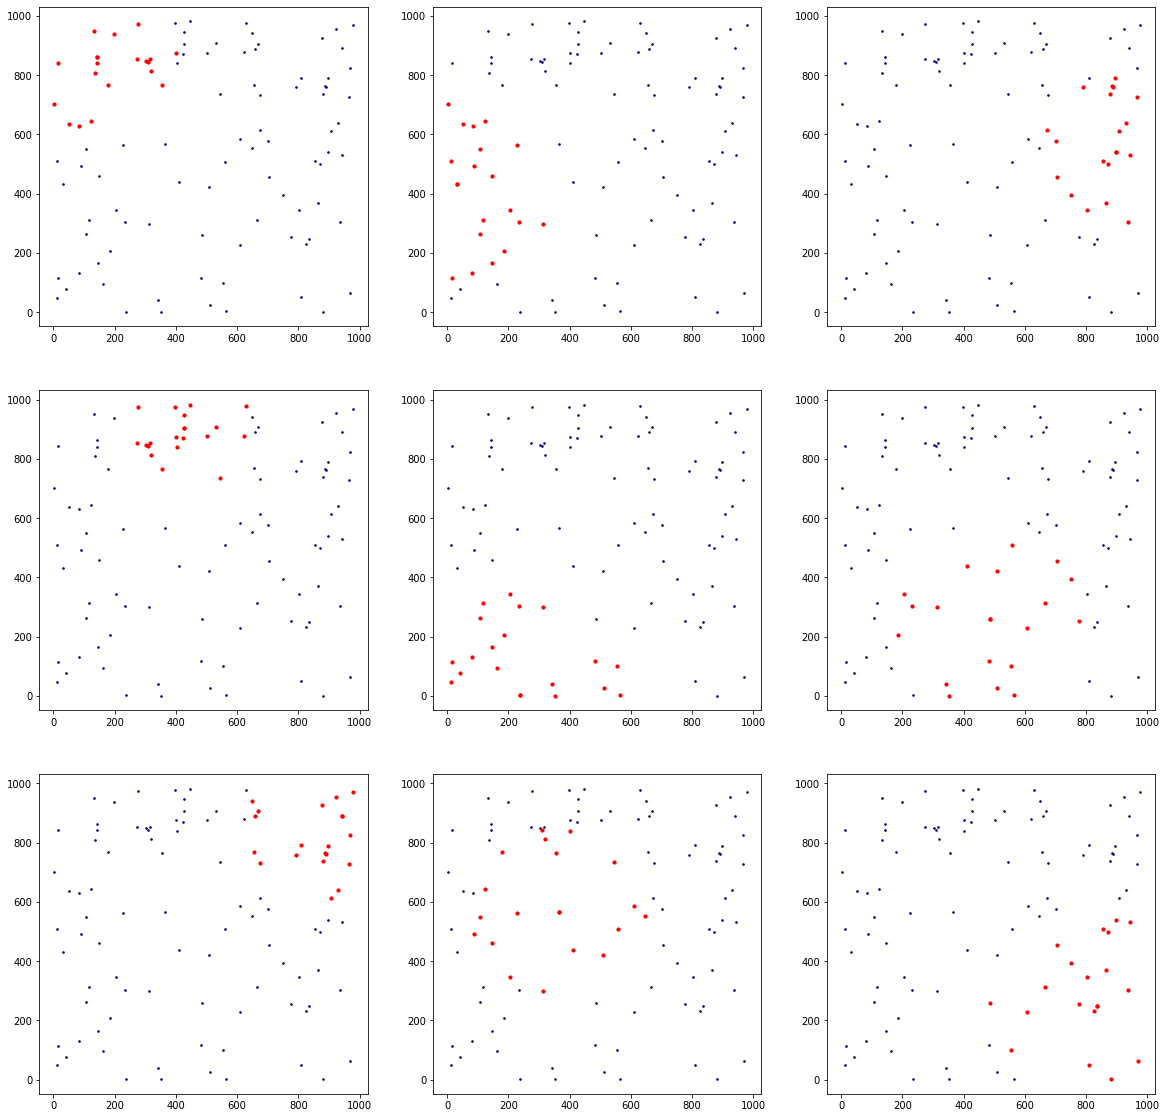

In [34]:
plt.figure(figsize=(20,20))

plt_dim = 3
fig, axs = plt.subplots(plt_dim, plt_dim)
fig.set_size_inches((20,20))

pos = coord_buff
for i in range( plt_dim ** 2):        
    axs[i // plt_dim, i % plt_dim].scatter(pos[:, 0], pos[:, 1], 10, color='darkblue', marker='.')

    samples = mesh[i][0][0]
    axs[i // plt_dim, i % plt_dim].scatter(pos[samples, 0], pos[samples, 1], 10, color='red', marker='o')
plt.show()

### 3. Loading trained Att-GCN based on TSP20-trainset

In [37]:
# model-parameter
config_path = "configs/tsp20.json"
config = get_config(config_path)

# setting random seed to 1
if torch.cuda.is_available():
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed_all(1)
else:
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)

In [39]:
# Instantiate the network
net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
if torch.cuda.is_available():
    net.cuda()  
# Define optimizer
learning_rate = config.learning_rate
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
# Load checkpoint
log_dir = f"./logs/{config.expt_name}/"
if torch.cuda.is_available():
    # TSP-20
    checkpoint = torch.load("logs/tsp20/best_val_checkpoint.tar")
else:
    checkpoint = torch.load("logs/tsp20/best_val_checkpoint.tar", map_location='cpu')
# Load network state
net.load_state_dict(checkpoint['model_state_dict'])
# Load optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# Load other training parameters
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
for param_group in optimizer.param_groups:
    learning_rate = param_group['lr']

#### 2.1 Heatmap generator on TSP20

In [44]:
threshold = len(edge)
batch_size = 1

config.expt_name = 'tsp{}'.format(inst_name)
num_nodes = n_points



In [55]:
# init
count_buff = np.zeros(shape=(batch_size*threshold, ), dtype=np.int32)
edges = np.zeros(shape=(batch_size*threshold, K+1, K+1), dtype=np.int32)
edges_values = np.zeros(shape=(batch_size*threshold, K+1, K+1), dtype=np.float16)
nodes = np.zeros(shape = (batch_size*threshold, K+1), dtype=np.int32)
nodes_coord = np.zeros(shape = (batch_size*threshold, K+1, 2), dtype=np.float16)
edges_target = np.zeros(shape = (batch_size*threshold, K+1, K+1), dtype=np.int32)
nodes_target = np.zeros(shape = (batch_size*threshold, K+1), dtype=np.int32)
meshs = np.zeros(shape = (batch_size*threshold, 2, K+1, K+1), dtype=np.int32)

Omegas = np.zeros(shape = (batch_size, num_nodes, num_nodes), dtype=np.int32)
opts = np.zeros(shape = (batch_size, num_nodes+1), dtype=np.int32)

In [72]:
print(len(edges_value), edges_value[0].shape)
print(edges_values.shape)
print(len(edge), edge[0].shape)
print(edges.shape)
#edges_values[0:25]

25 (2, 20, 20, 100)
(25, 20, 20)
25 (20, 20)
(25, 20, 20)


In [60]:
sum_time = 0

for i in range(batch_size):
        tsp_source = (coord_buff, optimal_tour)
        edge, edges_value, node, node_coord, edge_target, node_target, mesh, omega, opt = \
                test_one_tsp(tsp_source=tsp_source, \
                        coor_buff=coord_buff, node_num=n_points,  cluster_center=0, top_k=K, top_k_expand=K_expand)
        edges[i*threshold:(i+1)*threshold, ...] = edge
        edges_values[i*threshold:(i+1)*threshold, ...] = edges_value
        nodes[i*threshold:(i+1)*threshold, ...] = node
        nodes_coord[i*threshold:(i+1)*threshold, ...] = node_coord
        edges_target[i*threshold:(i+1)*threshold, ...] = edge_target
        nodes_target[i*threshold:(i+1)*threshold, ...] = node_target
        meshs[i*threshold:(i+1)*threshold, ...] = mesh

ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 3.

In [109]:
#print(len(edge), len(edges_value), len(nodes) )
print(meshs[0][0])
#print(omega.size)
#print(len(meshs[0]), meshs[0][0])


[[ 0 14 62 61 86 59 17 70  7 85 68 96 66 67 50 89 82 12 20 48]
 [ 0 14 62 61 86 59 17 70  7 85 68 96 66 67 50 89 82 12 20 48]
 [ 0 14 62 61 86 59 17 70  7 85 68 96 66 67 50 89 82 12 20 48]
 [ 0 14 62 61 86 59 17 70  7 85 68 96 66 67 50 89 82 12 20 48]
 [ 0 14 62 61 86 59 17 70  7 85 68 96 66 67 50 89 82 12 20 48]
 [ 0 14 62 61 86 59 17 70  7 85 68 96 66 67 50 89 82 12 20 48]
 [ 0 14 62 61 86 59 17 70  7 85 68 96 66 67 50 89 82 12 20 48]
 [ 0 14 62 61 86 59 17 70  7 85 68 96 66 67 50 89 82 12 20 48]
 [ 0 14 62 61 86 59 17 70  7 85 68 96 66 67 50 89 82 12 20 48]
 [ 0 14 62 61 86 59 17 70  7 85 68 96 66 67 50 89 82 12 20 48]
 [ 0 14 62 61 86 59 17 70  7 85 68 96 66 67 50 89 82 12 20 48]
 [ 0 14 62 61 86 59 17 70  7 85 68 96 66 67 50 89 82 12 20 48]
 [ 0 14 62 61 86 59 17 70  7 85 68 96 66 67 50 89 82 12 20 48]
 [ 0 14 62 61 86 59 17 70  7 85 68 96 66 67 50 89 82 12 20 48]
 [ 0 14 62 61 86 59 17 70  7 85 68 96 66 67 50 89 82 12 20 48]
 [ 0 14 62 61 86 59 17 70  7 85 68 96 66 67 50 89 82 12

In [88]:
np.meshgrid
#squareform(pdist(node_coord, 'euclidean'))
#np.eye(2,2)

array([[0.        , 1.15654562, 0.42951071, ..., 0.78144317, 0.55423403,
        0.83609544],
       [1.15654562, 0.        , 0.82310997, ..., 0.42302768, 0.65569914,
        0.42256899],
       [0.42951071, 0.82310997, 0.        , ..., 0.40523921, 0.16745104,
        0.63390721],
       ...,
       [0.78144317, 0.42302768, 0.40523921, ..., 0.        , 0.24031928,
        0.39368436],
       [0.55423403, 0.65569914, 0.16745104, ..., 0.24031928, 0.        ,
        0.49453428],
       [0.83609544, 0.42256899, 0.63390721, ..., 0.39368436, 0.49453428,
        0.        ]])

In [12]:
#df_ps
G

### 1. Loading trained Att-GCN based on TSP20-trainset

In [30]:
# model-parameter
config_path = "configs/tsp20.json"
config = get_config(config_path)

# setting random seed to 1
if torch.cuda.is_available():
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed_all(1)
else:
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)

In [31]:
# Instantiate the network
net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
if torch.cuda.is_available():
    net.cuda()  
# Define optimizer
learning_rate = config.learning_rate
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
# Load checkpoint
log_dir = f"./logs/{config.expt_name}/"
if torch.cuda.is_available():
    # TSP-20
    checkpoint = torch.load("logs/tsp20/best_val_checkpoint.tar")
else:
    checkpoint = torch.load("logs/tsp20/best_val_checkpoint.tar", map_location='cpu')
# Load network state
net.load_state_dict(checkpoint['model_state_dict'])
# Load optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# Load other training parameters
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
for param_group in optimizer.param_groups:
    learning_rate = param_group['lr']

### 2. Graph Sampling

In [ ]:
def multiprocess_write(sub_prob, meshgrid, omega, node_num = 20,
                       tsplib_name = './sample.txt', statiscs = False, opt = None):
    edges_probs = np.zeros(shape = (node_num, node_num), dtype = np.float32)
    for i in range(len(meshgrid)):
        edges_probs[list(meshgrid[i])] += sub_prob[i, :, :, 1]
    edges_probs = edges_probs / (omega + 1e-8)#[:, None]
    # normalize the probability in an instance 
    edges_probs = edges_probs + edges_probs.T
    edges_probs_norm = edges_probs/np.reshape(np.sum(edges_probs, axis=1),
                                              newshape=(node_num, 1))
    
    if statiscs:
        mean_rank = 0
        for i in range(node_num-1):
            mean_rank += len(np.where(edges_probs_norm[opt[i], :]>=edges_probs_norm[opt[i], opt[i+1]])[0]) 
        mean_rank /= (node_num-1)
        
        false_negative_edge = opt[np.where(edges_probs_norm[opt[:-1], opt[1:]]<1e-5)]
        # false negative edges in an instance
        num_fne = len(false_negative_edge)
        
        greater_zero_edges = len(np.where(edges_probs_norm>1e-6)[0])
        greater_zero_edges /= node_num
        
        write_tsplib_prob(tsplib_name, edge_prob = edges_probs_norm,
                  num_node=node_num, mean=mean_rank, fnn = num_fne, greater_zero=greater_zero_edges)
    else:
        write_tsplib_prob(tsplib_name, edge_prob = edges_probs_norm,
                          num_node=node_num, mean=0, fnn = 0, greater_zero=0)
    return mean_rank
net.eval()

In [40]:
num_nodes = 20
line = "0.029157934210713665 0.1559301825892634 0.03435471062405426 0.7682971106073093 0.3697166746406534 0.5018496299184007 0.5773199862704034 0.17172052933909687 0.6784428933051259 0.6975873582228431 0.4431051403147942 0.7493119574690765 0.49048884441003426 0.045469091760450664 0.2133731527472742 0.252152704752452 0.5318604857631822 0.5209111757162382 0.7537092753509504 0.3978239530415303 0.47850191065669456 0.17205353946229118 0.3924481462412055 0.7350983993831633 0.6946311107051806 0.15934358561054696 0.3872115247972211 0.7711203871028484 0.5645252549207432 0.5377147033696458 0.026977874388971146 0.7541423744086744 0.07421254499896157 0.6490227171133383 0.4358126035976637 0.5393203190426608 0.35101053789891434 0.07192098491162946 0.7752470640361943 0.10874604545820277 output 1 8 19 7 11 4 13 20 10 5 15 9 18 3 6 12 14 2 16 17 1"
tsp_source = line
buff_coor = np.zeros(shape=(num_nodes, 2), dtype = np.float64)

coor, opt = tsp_instance_reader(tspinstance=tsp_source,
                       buff = buff_coor, num_node=num_nodes)




In [42]:
print(coor.shape)

(20, 2)
